# METU Ceng 798 - Quantum Computing Term Project
## Grover's Algorithm for String Matching
### Mert Tunc - 2023 Spring


In this project, we will implement [Grover's algorithm](https://learn.qiskit.org/course/ch-algorithms/grovers-algorithm) for string matching. The problem is defined as follows:
Given a string $w$ of length $n$ and a pattern $p$ of length $m$, find all the starting positions of $p$ in $w$.

In the linerature, there are three papers claiming they solved the string matching problem with the help of Grover's algorithm. The first one is [1] and the second one is [2].

In this project, I tried to implement a similar and a novel way of solving the string matching problem with the Grover's algorithm.

[1] https://doi.org/10.1038/s41534-021-00369-3
[2] https://www.sciencedirect.com/science/article/pii/S1570866703000108

So first, let us define the imports we'll use,

In [1]:
import math

from qiskit.visualization import plot_histogram
from qiskit import transpile
from qiskit import QuantumCircuit, QuantumRegister
from qiskit_ibm_provider import IBMProvider

provider = IBMProvider()

And define the variables we'll use,
as in the original statement, we have $w$ and $p$ as the string and the pattern respectively.

In the implementation, it is assumed that the $n$ and $m$ have a length of power 2.

In [2]:
inp_w = "1101"
inp_p = "01"

In [3]:
n = len(inp_w)
m = len(inp_p)

In [4]:
assert n >= m, "n must be greater than m"
assert m >= 1, "m must be greater than 0"
assert 2 ** int(math.log2(n)) == n, "n must be a power of 2"
assert 2 ** int(math.log2(m)) == m, "m must be a power of 2"

Now, we need to start implementing the actual solution. For the above examples, we see that the match occurs starting from the 2nd index of $w$, represented as $10$ in binary.

Grover's search algorithm shares a framework with us on how to implement unstructured search with a time complexity of $O(\sqrt{n})$

The framework is as follows:
- Initialize the state $|s\rangle$ to a uniform superposition of all possible states.
- Repeat the following steps $O(\sqrt{n})$ times:
    - Apply the oracle $U_f$ to the state $|s\rangle$.
    - Apply the diffusion operator $U_s$ to the state $|s\rangle$.
- Measure the state $|s\rangle$.

Following image is an illustration of the steps of Grover's Algorithm
![Grovers Illustration](https://learn.qiskit.org/content/v2/ch-algorithms/images/grover_circuit_high_level.png)


In our application, the states that we want to search are consist of the starting index of the pattern in the string. For the values we defined above, we have $w = 1101$ and $p = 01$. In this input, the states we will be searching are $00, 01, 10$. The challenge in the string search, these states bring more than one constraint.

So in our example $w$ and $p$, the state $01$ means that:
- $w_1$ = $p_0$
- $w_2$ = $p_1$


Generailzation of the constraints for any $w$ and $p$ is as follows:
Given:
- A state s in binary form representing the start position of the match and
- A $p$ of length $k$:
Constraints to check if the state $s$ is a match:
- $w_{s + 0} = p_0$
- $w_{s + 1} = p_1$
- ...
- $w_{s + k} = p_k$

Let's implement these checks in our oracle. In addition to these constrains, we'll also need to do several things for the implementation:
- Checking if a bit in $w$ and $p$ being equal or not requires these bits to flipped to 1 before the operation and after the operation if these bits are 0.
- Similarly, we'll need to flip the bits of $s$ if these are 0.
- For each constrain, we'll store the equilavence in a intermediate qubit, then use a multi controlled and gate to and all of them to a single qubit.We'll call these intermediate qubits as `bit_matches`, with a length of $p$, and the final qubit as `match`.


So define the circuit first and initialize the $s$ with Hadamard gates.

In [5]:
num_sbits = math.ceil(math.log2(n - m)) + 1 # Number of bits required for s to encode all possible start indexes of matches

s = QuantumRegister(num_sbits, 's_list')
#s_chunks = list(list_to_chunks(s_list, num_sbits))
w = QuantumRegister(n, 'w') # w is the string to be searched
p = QuantumRegister(m, 'p') # p is the pattern to be searched in w
bit_matches = QuantumRegister(m, 'bit_matches') # bit_matches is the intermediate qubits to store the individual constraints
match = QuantumRegister(1, 'match') # match is the final qubit to store the result of the oracle

qc = QuantumCircuit(s, w, p, bit_matches, match) # all qubits will have starting state of |0>

In [6]:
def set_inputs(qc, inp_w, inp_p):
    """Negate the initial |0> states of s correspondingly to the input w and p"""
    for i, c in enumerate(inp_w):
        if c == "1":
            qc.x(w[i])

    for i, c in enumerate(inp_p):
        if c == "1":
            qc.x(p[i])


def initialize_s(qc):
    """Apply H gates to all qubits in s"""
    qc.h(s)


In [7]:
set_inputs(qc, inp_w, inp_p)
initialize_s(qc)

Now, we can define an oracle that checks the constraints we defined above.

In [8]:
def oracle(qc: QuantumCircuit, start_pos):
    format_string = "{:0" + str(len(s)) + "b}"
    pos_in_binary = format_string.format(start_pos)

    # flipped_x valiables will hold which qubits are flipped in the oracle to revert them back after the mxc gates.
    flipped_s = []
    for k, pos in enumerate(pos_in_binary):
        if pos == "0":
            flipped_s.append(s[k])
            qc.x(s[k])

    # Following for loop will create the $w_{s + k} = p_k$ for each bit in p
    # offset is the k, match_bit is intermediate qubit to store the result of the constraint
    for offset, match_bit in enumerate(bit_matches):
        flipped_w = []
        flipped_p = []

        if inp_p[0 + offset] == "0":
            flipped_p.append(p[0 + offset])
            qc.x(p[0 + offset])

            flipped_w.append(w[0 + start_pos + offset])
            qc.x(w[0 + start_pos + offset])

        # Following gate can be read as: For the current state of s , if w[start_pos + offset] and p[0 + offset] is the same
        # Apply X gate to bit_matches[offset], to store the result of the constraint
        qc.mcx(list(s) + [w[start_pos + offset], p[0 + offset]], bit_matches[offset])

        # Revert what we flipped to have 1 in mcx inputs
        if len(flipped_w):
            qc.x(flipped_w)
        if len(flipped_p):
            qc.x(flipped_p)

    if len(flipped_s):
        qc.x(flipped_s)

In addition to the oracle, we'll also need to define the diffusion operator. The diffusion operator is defined as follows:

In [9]:
def diffusion(qc: QuantumCircuit):
    """Apply a diffusion circuit to the register 's' in qc"""
    qc.h(s)
    qc.x(s)

    qc.mcx(s, match)
    qc.z(match)

    qc.x(s)
    qc.h(s)

Now, we are almost done, we need to apply these oracle and diffusion opeartors $O(\sqrt{N})$ times, where $N$ is $\sqrt(2*len(s))$

In [10]:
# Following line and barriers on qc is for demonstration purposes only
format_string = "{:0" + str(len(s)) + "b}"

num_repetitions = int(math.sqrt(2 ** (num_sbits)))
for repetition in range(num_repetitions):
    qc.barrier(label=f"Oracle start")
    for start_pos in range(n - m + 1):
        pos_in_binary = format_string.format(start_pos)
        qc.barrier(label=f"{pos_in_binary} St.")
        # Apply the oracle, and then extract the match qubit if all intermediate bit_matches are 1,
        # then apply the oracle again to revert the changes we made on bit_matches
        oracle(qc, start_pos)
        qc.mcx(bit_matches, match)
        oracle(qc, start_pos)

        qc.barrier(label=f"{pos_in_binary} End.")
    # We then apply the diffusion operator to rotate all probabilities of the states around the mean.
    qc.barrier(label=f"Diffusion start")

    diffusion(qc)


To measure what we got on $s$ qubits, we define a measurement and append that to the circuit.

In [11]:
def measurement_s(qc):
    num_bits = len(s)
    meas = QuantumCircuit(num_bits, num_bits)
    meas.measure(list(range(num_bits)), list(range(num_bits)))
    qc.compose(meas, inplace=True, qubits=s)

measurement_s(qc)

Then, run the circuit on a simulator and plot the results.

In [12]:
def execute_on_sim(qc, num_shots=100):
    backend = provider.get_backend('ibmq_qasm_simulator')
    result = backend.run(transpile(qc, backend), shots=num_shots).result()
    return result.get_counts(qc)


counts = execute_on_sim(qc)

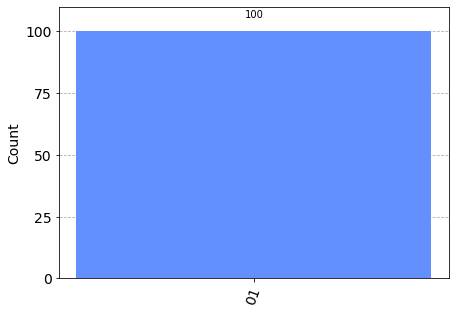

In [13]:
plot_histogram(counts)

In the above plot, we can see that on 1000 shots on simulator, we got only the $10$ match, which is 2 in decimal notation.
Our $w$ was $1101$ and $p$ was $01$, and we got the correct result.(There is indeed a match of p starting from the index 2 in w)

Let's see the circuit we built solving the string matching problem

In [14]:
qc.draw(fold=100)

┌───┐ Oracle start  00 St. ┌───┐               ┌───┐┌───┐               ┌───┐»
     s_list_0: ┤ H ├──────░──────────░────┤ X ├──■─────────■──┤ X ├┤ X ├──■─────────■──┤ X ├»
               ├───┤      ░          ░    ├───┤  │         │  ├───┤├───┤  │         │  ├───┤»
     s_list_1: ┤ H ├──────░──────────░────┤ X ├──■─────────■──┤ X ├┤ X ├──■─────────■──┤ X ├»
               ├───┤      ░          ░    ├───┤  │  ┌───┐  │  ├───┤└───┘  │  ┌───┐  │  └───┘»
          w_0: ┤ X ├──────░──────────░────┤ X ├──■──┤ X ├──┼──┤ X ├───────■──┤ X ├──┼───────»
               ├───┤      ░          ░    └───┘  │  └───┘  │  └───┘       │  └───┘  │       »
          w_1: ┤ X ├──────░──────────░───────────┼─────────■──────────────┼─────────■───────»
               └───┘      ░          ░           │         │              │         │       »
          w_2: ───────────░──────────░───────────┼─────────┼──────────────┼─────────┼───────»
               ┌───┐      ░          ░           │         │              │         │       »
          w_3: ┤ X ├──────░──────────░───────────┼─────────┼──────────────┼─────────┼───────»
               └───┘      ░          ░    ┌───┐  │  ┌───┐  │  ┌───┐       │  ┌───┐  │       »
          p_0: ───────────░──────────░────┤ X ├──■──┤ X ├──┼──┤ X ├───────■──┤ X ├──┼───────»
               ┌───┐      ░          ░    └───┘  │  └───┘  │  └───┘       │  └───┘  │       »
          p_1: ┤ X ├──────░──────────░───────────┼─────────■──────────────┼─────────■───────»
               └───┘      ░          ░         ┌─┴─┐       │            ┌─┴─┐       │       »
bit_matches_0: ───────────░──────────░─────────┤ X ├───────┼────■───────┤ X ├───────┼───────»
                          ░          ░         └───┘     ┌─┴─┐  │       └───┘     ┌─┴─┐     »
bit_matches_1: ───────────░──────────░───────────────────┤ X ├──■─────────────────┤ X ├─────»
                          ░          ░                   └───┘┌─┴─┐               └───┘     »
        match: ───────────░──────────░────────────────────────┤ X ├─────────────────────────»
                          ░          ░                        └───┘                         »
          c: 2/═════════════════════════════════════════════════════════════════════════════»
                                                                                            »
«                00 End.  01 St. ┌───┐               ┌───┐┌───┐               ┌───┐ 01 End. »
«     s_list_0: ────░───────░────┤ X ├──■─────────■──┤ X ├┤ X ├──■─────────■──┤ X ├────░────»
«                   ░       ░    └───┘  │         │  └───┘└───┘  │         │  └───┘    ░    »
«     s_list_1: ────░───────░───────────■─────────■──────────────■─────────■───────────░────»
«                   ░       ░           │         │              │         │           ░    »
«          w_0: ────░───────░───────────┼─────────┼──────────────┼─────────┼───────────░────»
«                   ░       ░    ┌───┐  │  ┌───┐  │  ┌───┐       │  ┌───┐  │           ░    »
«          w_1: ────░───────░────┤ X ├──■──┤ X ├──┼──┤ X ├───────■──┤ X ├──┼───────────░────»
«                   ░       ░    └───┘  │  └───┘  │  └───┘       │  └───┘  │           ░    »
«          w_2: ────░───────░───────────┼─────────■──────────────┼─────────■───────────░────»
«                   ░       ░           │         │              │         │           ░    »
«          w_3: ────░───────░───────────┼─────────┼──────────────┼─────────┼───────────░────»
«                   ░       ░    ┌───┐  │  ┌───┐  │  ┌───┐       │  ┌───┐  │           ░    »
«          p_0: ────░───────░────┤ X ├──■──┤ X ├──┼──┤ X ├───────■──┤ X ├──┼───────────░────»
«                   ░       ░    └───┘  │  └───┘  │  └───┘       │  └───┘  │           ░    »
«          p_1: ────░───────░───────────┼─────────■──────────────┼─────────■───────────░────»
«                   ░       ░         ┌─┴─┐       │            ┌─┴─┐       │           ░    »
«bit_matches_0: ────░───────░─────────┤ X ├───────┼────■───────┤ X 


---


Now, let's see the limits of the implementation. We'll try to search for a pattern of length 4 in a string of length 8. We'll also have two matches.
Lets re-define $w$, and $p$

In [15]:
inp_w = "11010001"
inp_p = "01"
n = len(inp_w)
m = len(inp_p)

In [16]:
assert n >= m, "n must be greater than m"
assert m >= 1, "m must be greater than 0"
assert 2 ** int(math.log2(n)) == n, "n must be a power of 2"
assert 2 ** int(math.log2(m)) == m, "m must be a power of 2"

In [17]:
num_sbits = math.ceil(math.log2(n - m)) + 1 # Number of bits required for s to encode all possible start indexes of matches

s = QuantumRegister(num_sbits, 's_list')
#s_chunks = list(list_to_chunks(s_list, num_sbits))
w = QuantumRegister(n, 'w') # w is the string to be searched
p = QuantumRegister(m, 'p') # p is the pattern to be searched in w
bit_matches = QuantumRegister(m, 'bit_matches') # bit_matches is the intermediate qubits to store the individual constraints
match = QuantumRegister(1, 'match') # match is the final qubit to store the result of the oracle

qc = QuantumCircuit(s, w, p, bit_matches, match) # all qubits will have starting state of |0>

In [18]:
set_inputs(qc, inp_w, inp_p)
initialize_s(qc)

num_repetitions = int(math.sqrt(2 ** (num_sbits)))
for repetition in range(num_repetitions):
    for start_pos in range(n - m + 1):
        # Apply the oracle, and then extract the match qubit if all intermediate bit_matches are 1,
        # then apply the oracle again to revert the changes we made on bit_matches
        oracle(qc, start_pos)
        qc.mcx(bit_matches, match)
        oracle(qc, start_pos)
    # We then apply the diffusion operator to rotate all probabilities of the states around the mean.
    diffusion(qc)

measurement_s(qc)

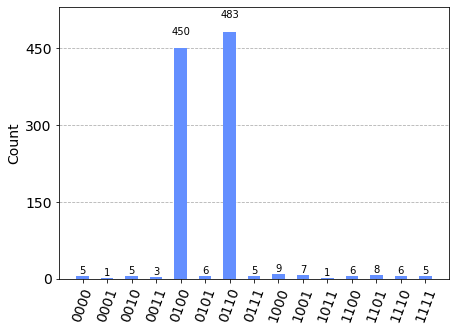

In [19]:
import time

start_time = time.monotonic()

counts = execute_on_sim(qc, num_shots=1000)
plot_histogram(counts)

In [20]:
# Keep in mind that we are using IBM's simulator and it is on their backend.
print('Elapsed seconds(For 1000 shots on simulator): ', time.monotonic() - start_time)

Elapsed seconds(For 1000 shots on simulator):  36.289467948


It is clearly visible that the states $0010$(2 in decimal) and $0110$(6 in decimal) is the most probable states, which are the correct answers.